# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!
device

device(type='cuda', index=0)

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('../data',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('../data', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = 0.2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))

np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [41]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # Don't forget to move the data to device before running it through the model!
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct, num_samples = 0, 0
    with torch.no_grad():
        for X, y in loader:
            x_gpu = X.to(device)
            y_gpu = y.to(device)
            pred = model(x_gpu)
            correct += (pred.argmax(1) == y_gpu).type(torch.float).sum().item()
            num_samples += y_gpu.shape[0]
    return correct / num_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.347823, Train accuracy: 0.552333, Val accuracy: 0.735922
Average loss: 0.683061, Train accuracy: 0.794373, Val accuracy: 0.795168
Average loss: 0.588579, Train accuracy: 0.825769, Val accuracy: 0.828681
Average loss: 0.535687, Train accuracy: 0.841723, Val accuracy: 0.835711
Average loss: 0.506296, Train accuracy: 0.849674, Val accuracy: 0.852706


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [8]:
from PIL import Image

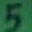

In [9]:
img =  Image.fromarray(data_test.data[0].transpose(1, 2, 0))
img

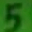

In [10]:
tr_jitter = transforms.ColorJitter(hue=0.5, saturation=0.5)
tr_jitter(img)

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('../data',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

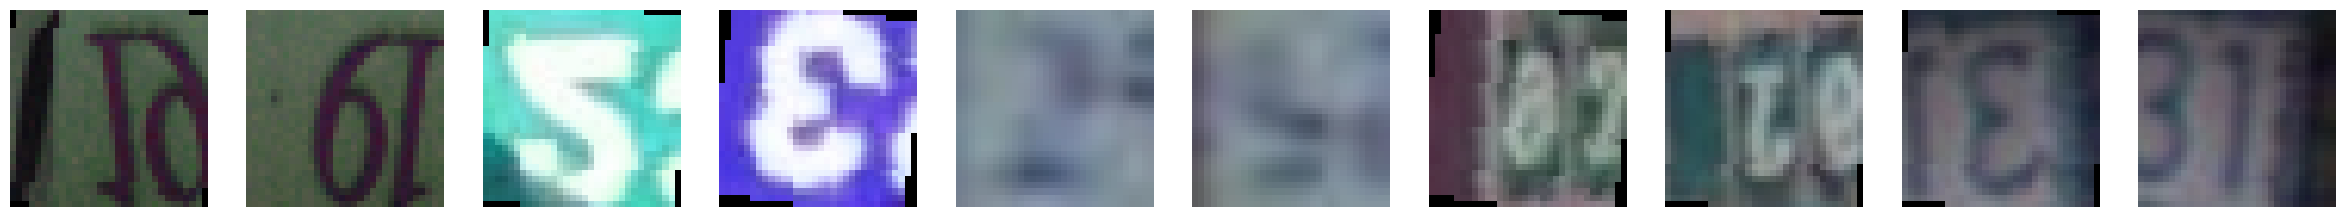

In [12]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
])

data_aug_vis = dset.SVHN('../data',
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Случайные изображения каждый раз

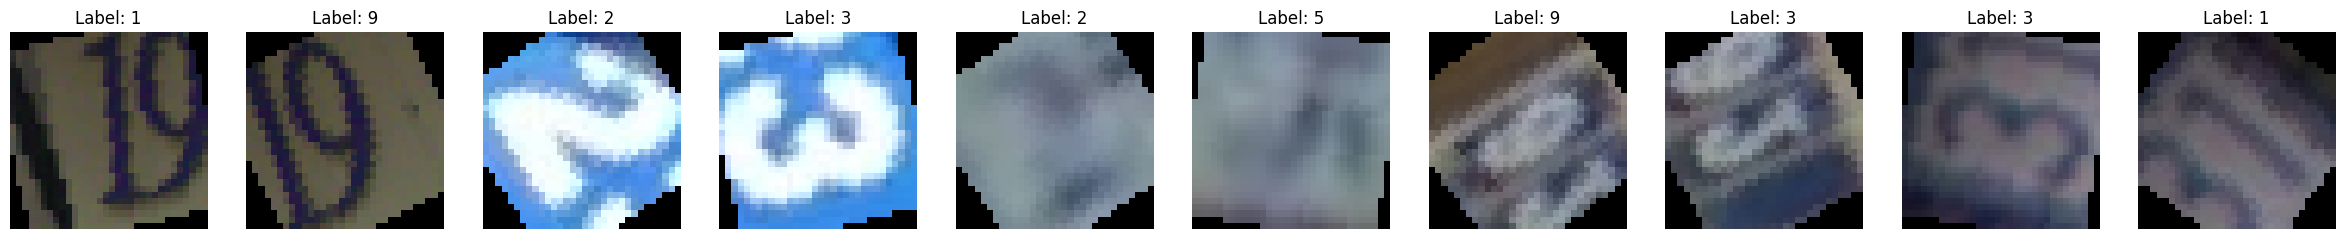

In [13]:
tfs_jitter = transforms.Compose([
    transforms.RandomRotation(100),
    transforms.ToTensor(),
])

data_aug_vis = dset.SVHN('../data', transform=tfs_jitter)
data_loader = torch.utils.data.DataLoader(data_aug_vis, batch_size=1, shuffle=False)

plt.figure(figsize=(30, 3))
for i, (x_batch, y_batch) in enumerate(data_loader):
    if i == 10:
        break
    x = x_batch[0].permute(1, 2, 0)
    y = y_batch[0]
    plt.subplot(1, 10, i + 1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis("off")
    plt.title(f'Label: {y}')

Можно:
- ColorJitter
- RandomRotation - непонятно какие градусы брать


Нельзя:
- RandomHorizontalFlip
- RandomVerticalFlip

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [14]:
tfs_train = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

train_aug_data = dset.SVHN("../data", transform=tfs_train)
train_aug_loader = torch.utils.data.DataLoader(train_aug_data, batch_size=batch_size, sampler=train_sampler)

In [42]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.590219, Train accuracy: 0.819762, Val accuracy: 0.837008
Average loss: 0.577683, Train accuracy: 0.824318, Val accuracy: 0.845267
Average loss: 0.568773, Train accuracy: 0.825769, Val accuracy: 0.840147
Average loss: 0.561100, Train accuracy: 0.829454, Val accuracy: 0.842400
Average loss: 0.553895, Train accuracy: 0.830273, Val accuracy: 0.862330


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [19]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=1)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [20]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.368287, Train accuracy: 0.538290, Val accuracy: 0.830797
Average loss: 0.567688, Train accuracy: 0.829864, Val accuracy: 0.870862
Average loss: 0.480127, Train accuracy: 0.856380, Val accuracy: 0.881032
Average loss: 0.433445, Train accuracy: 0.870201, Val accuracy: 0.882875
Average loss: 0.396288, Train accuracy: 0.881019, Val accuracy: 0.889973
Average loss: 0.379217, Train accuracy: 0.885899, Val accuracy: 0.855846
Average loss: 0.361196, Train accuracy: 0.890899, Val accuracy: 0.891543
Average loss: 0.345970, Train accuracy: 0.894482, Val accuracy: 0.892226
Average loss: 0.332092, Train accuracy: 0.899174, Val accuracy: 0.899051
Average loss: 0.320019, Train accuracy: 0.903593, Val accuracy: 0.891407


# Подбор гиперпараметров

In [25]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

space = {
    "lr" : hp.uniform("lr", 1e-4, 1e0),
    "anneal_coeff" : 0.2,
    "anneal_epochs" : hp.randint("a_e", 5, 50),
    "reg" : hp.uniform("reg", 1e-7, 1e-3)
}

def score(params):
    print("Params:", params)
    lenet_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Flattener(),
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=1)
          )

    lenet_model.type(torch.cuda.FloatTensor)
    lenet_model.to(device)

    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=params["reg"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params["anneal_epochs"], gamma="anneal_coeff")
    epochs = 5
    loss_history, train_history, val_history = train_model(lenet_model,
                                                           train_aug_loader, val_loader,
                                                           loss, optimizer, epochs)

    score = val_history[-1]
    print(f"Score: {score}")
    return {"loss": -score, "status": STATUS_OK}

def optimize(trials, space, max_evals=10):
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=max_evals)
    return best

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trials = Trials()
best_params = optimize(trials, space, 20)

Params:                                               
{'anneal_coeff': 0.2, 'anneal_epochs': 23.411686756642613, 'lr': 0.6158159687029297, 'reg': 0.00034822884114209425}
Average loss: 1.422086, Train accuracy: 0.518394, Val accuracy: 0.814484
Average loss: 0.584853, Train accuracy: 0.824574, Val accuracy: 0.828476
Average loss: 0.489581, Train accuracy: 0.853889, Val accuracy: 0.868883
Average loss: 0.440665, Train accuracy: 0.867932, Val accuracy: 0.884308
Average loss: 0.411186, Train accuracy: 0.876941, Val accuracy: 0.876322
Score: 0.8763224353286465                             
Params:                                                                             
{'anneal_coeff': 0.2, 'anneal_epochs': 20.73683871936005, 'lr': 0.22799070008605116, 'reg': 0.0009169627026873799}
Average loss: 1.335768, Train accuracy: 0.552964, Val accuracy: 0.824858            
Average loss: 0.579435, Train accuracy: 0.826127, Val accuracy: 0.855983            
Average loss: 0.490399, Train accuracy:

KeyboardInterrupt: 

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [197]:
class My_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_stack = nn.Sequential(
            nn.Conv2d(3, 64, 3,),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(128 * 5 * 5, 128 * 5 * 5 // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128 * 5 * 5 // 2, 10)
        )

    def forward(self, x):
        x = self.cnn_stack(x)
        x = self.flatten(x)
        pred = self.linear_stack(x)
        return pred

In [198]:
my_cnn_model = My_CNN()

my_cnn_model.type(torch.cuda.FloatTensor)
my_cnn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(my_cnn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [225]:
loss_history, train_history, val_history = train_model(my_cnn_model,
                                                              train_aug_loader, val_loader,
                                                           loss, optimizer, 3)

Average loss: 0.140931, Train accuracy: 0.958127, Val accuracy: 0.947376
Average loss: 0.130702, Train accuracy: 0.960601, Val accuracy: 0.945464
Average loss: 0.122708, Train accuracy: 0.962444, Val accuracy: 0.942530


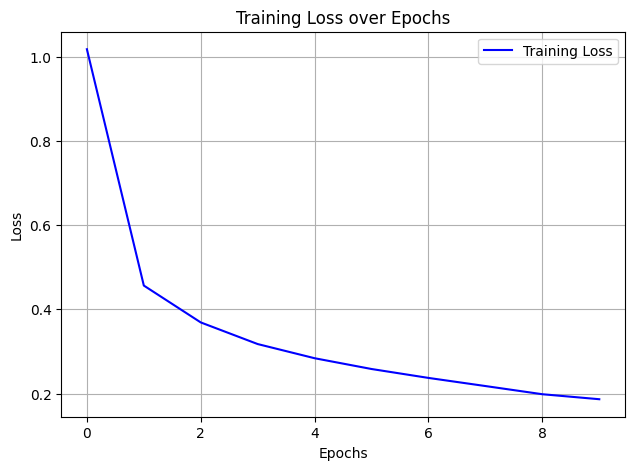

In [200]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

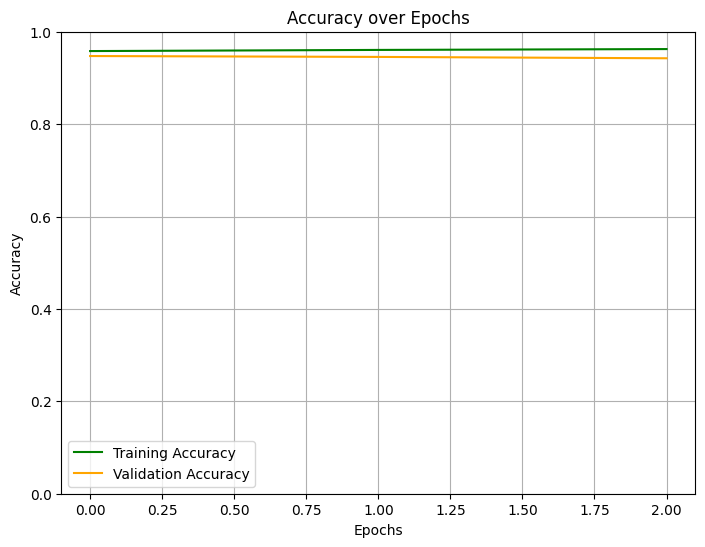

In [226]:
# График точности
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 2)
plt.plot(train_history, label='Training Accuracy', color='green')
plt.plot(val_history, label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Установите диапазон Y от 0 до 1 для точности
plt.grid()
plt.legend()

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [227]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(my_cnn_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9435694529809465


In [228]:
# Преобразования для MNIST
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Изменяем размер до 32x32
    transforms.Grayscale(num_output_channels=3),  # Дублируем канал, чтобы получить 3 канала
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43, 0.44, 0.47], std=[0.20, 0.20, 0.20])  # Нормализация, как на SVHN
])

# Загрузка MNIST
mnist_test = dset.MNIST(root='../data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

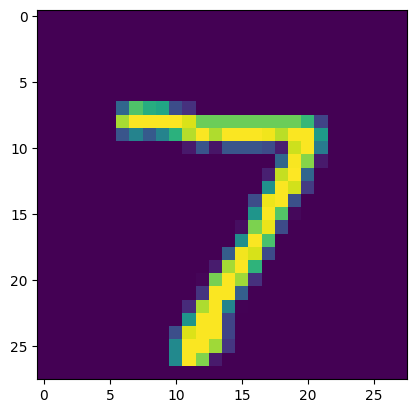

In [229]:
plt.imshow(test_loader.dataset.data[0])

In [230]:
mnist_accuracy = compute_accuracy(my_cnn_model, test_loader)
print(f'MNIST Test Accuracy: {mnist_accuracy * 100:.2f}%')

MNIST Test Accuracy: 76.85%


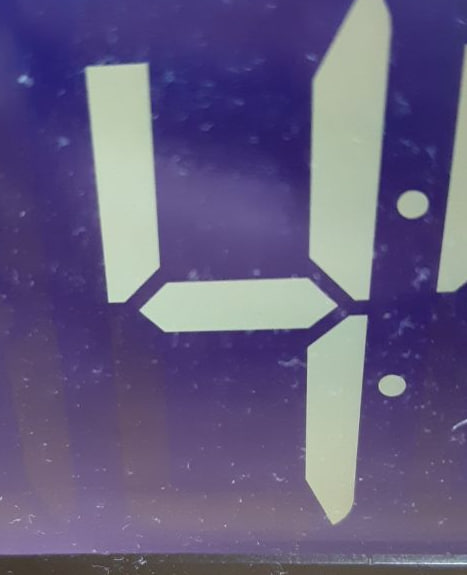

In [231]:
my_image = PIL.Image.open("../data/my_image_4.png")
my_image

In [232]:
transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                        std=[0.20,0.20,0.20])
])

my_image_transformed = transform(my_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


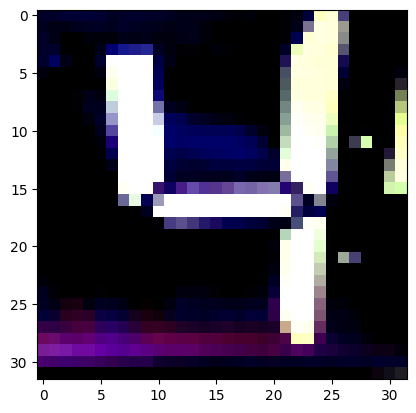

In [233]:
plt.imshow(my_image_transformed.permute(1, 2, 0))

In [234]:
image_tensor = my_image_transformed.unsqueeze(0)
image_tensor = image_tensor.to(device)

In [235]:
with torch.no_grad():
    res = my_cnn_model(image_tensor)
    print(res)
    _, pred = torch.max(res, 1)
    print(pred.item())

tensor([[-1.8807, -0.2028, -1.9961, -0.3875,  2.6565,  2.0870, -0.7917, -0.4132,
         -0.6334,  1.0850]], device='cuda:0')
4
